In [1]:
import time
import random
import numpy as np
import importlib

import sys
sys.path.append("../../")

In [2]:
from qiskit import QuantumProgram
import Qconfig

In [3]:
import tools.Experiment_tools as exptool

In [4]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/home/christophe/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

In [5]:
qprogram = QuantumProgram()
qprogram.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [6]:
api = qprogram.get_api()

In [7]:
qprogram.available_backends()

['ibmqx4',
 'ibmqx2',
 'ibmqx5',
 'ibmqx_qasm_simulator',
 'local_qasm_simulator',
 'local_unitary_simulator']

In [8]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 0, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 150}

In [9]:
config = qprogram.get_backend_configuration("ibmqx4",list_format=True)
config

{'basis_gates': 'SU2+CNOT',
 'chip_name': 'Raven',
 'coupling_map': [[1, 0], [2, 0], [2, 1], [2, 4], [3, 2], [3, 4]],
 'description': '5 qubit transmon bowtie chip 3',
 'n_qubits': 5,
 'name': 'ibmqx4',
 'online_date': '2017-09-18T11:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx4',
 'version': '1'}

In [10]:
n = config['n_qubits']
q = qprogram.create_quantum_register("q",n)
c = qprogram.create_classical_register("c",n)

In [11]:
circuit_names = exptool.all_circuits(qprogram,config['coupling_map'])

In [12]:
rand_perm_names = np.random.permutation(circuit_names)
batches = [list(rand_perm_names[50*j:50*(j+1)]) for j in range(0,1+int(len(circuit_names)/50))]

compiled_qobj_list = [qprogram.compile(batch, 
                                       backend='ibmqx4', 
                                       config=None,
                                       silent=False, 
                                       basis_gates=None, 
                                       coupling_map=None, 
                                       initial_layout=None, 
                                       shots=8192, 
                                       max_credits=5, 
                                       seed=None) for batch in batches]

In [49]:
qprogram.run_batch_async(compiled_qobj_list, wait=2, timeout=6, silent=True, callback=exptool.post_treatment_list)

In [13]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 0, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 150}

In [14]:
print(exptool.fetch_previous('timed_out.txt',api))
print(exptool.fetch_previous('completed.txt',api))

27
0


In [15]:
dict_cn = exptool.get_qasm_name_dict(compiled_qobj_list)

In [16]:
print(exptool.process_all_api_dumps('data/completed_timed_out.txt','data/already_processed.txt',dict_cn))
print(exptool.process_all_api_dumps('data/completed_completed.txt','data/already_processed.txt',dict_cn))
print(exptool.process_all_api_dumps('data/completed_timed_out_old.txt','data/already_processed.txt',dict_cn))

27
0
0


In [22]:
importlib.reload(exptool)
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [23]:
#exptool.plot_everything_raw('data/Processed_data/')

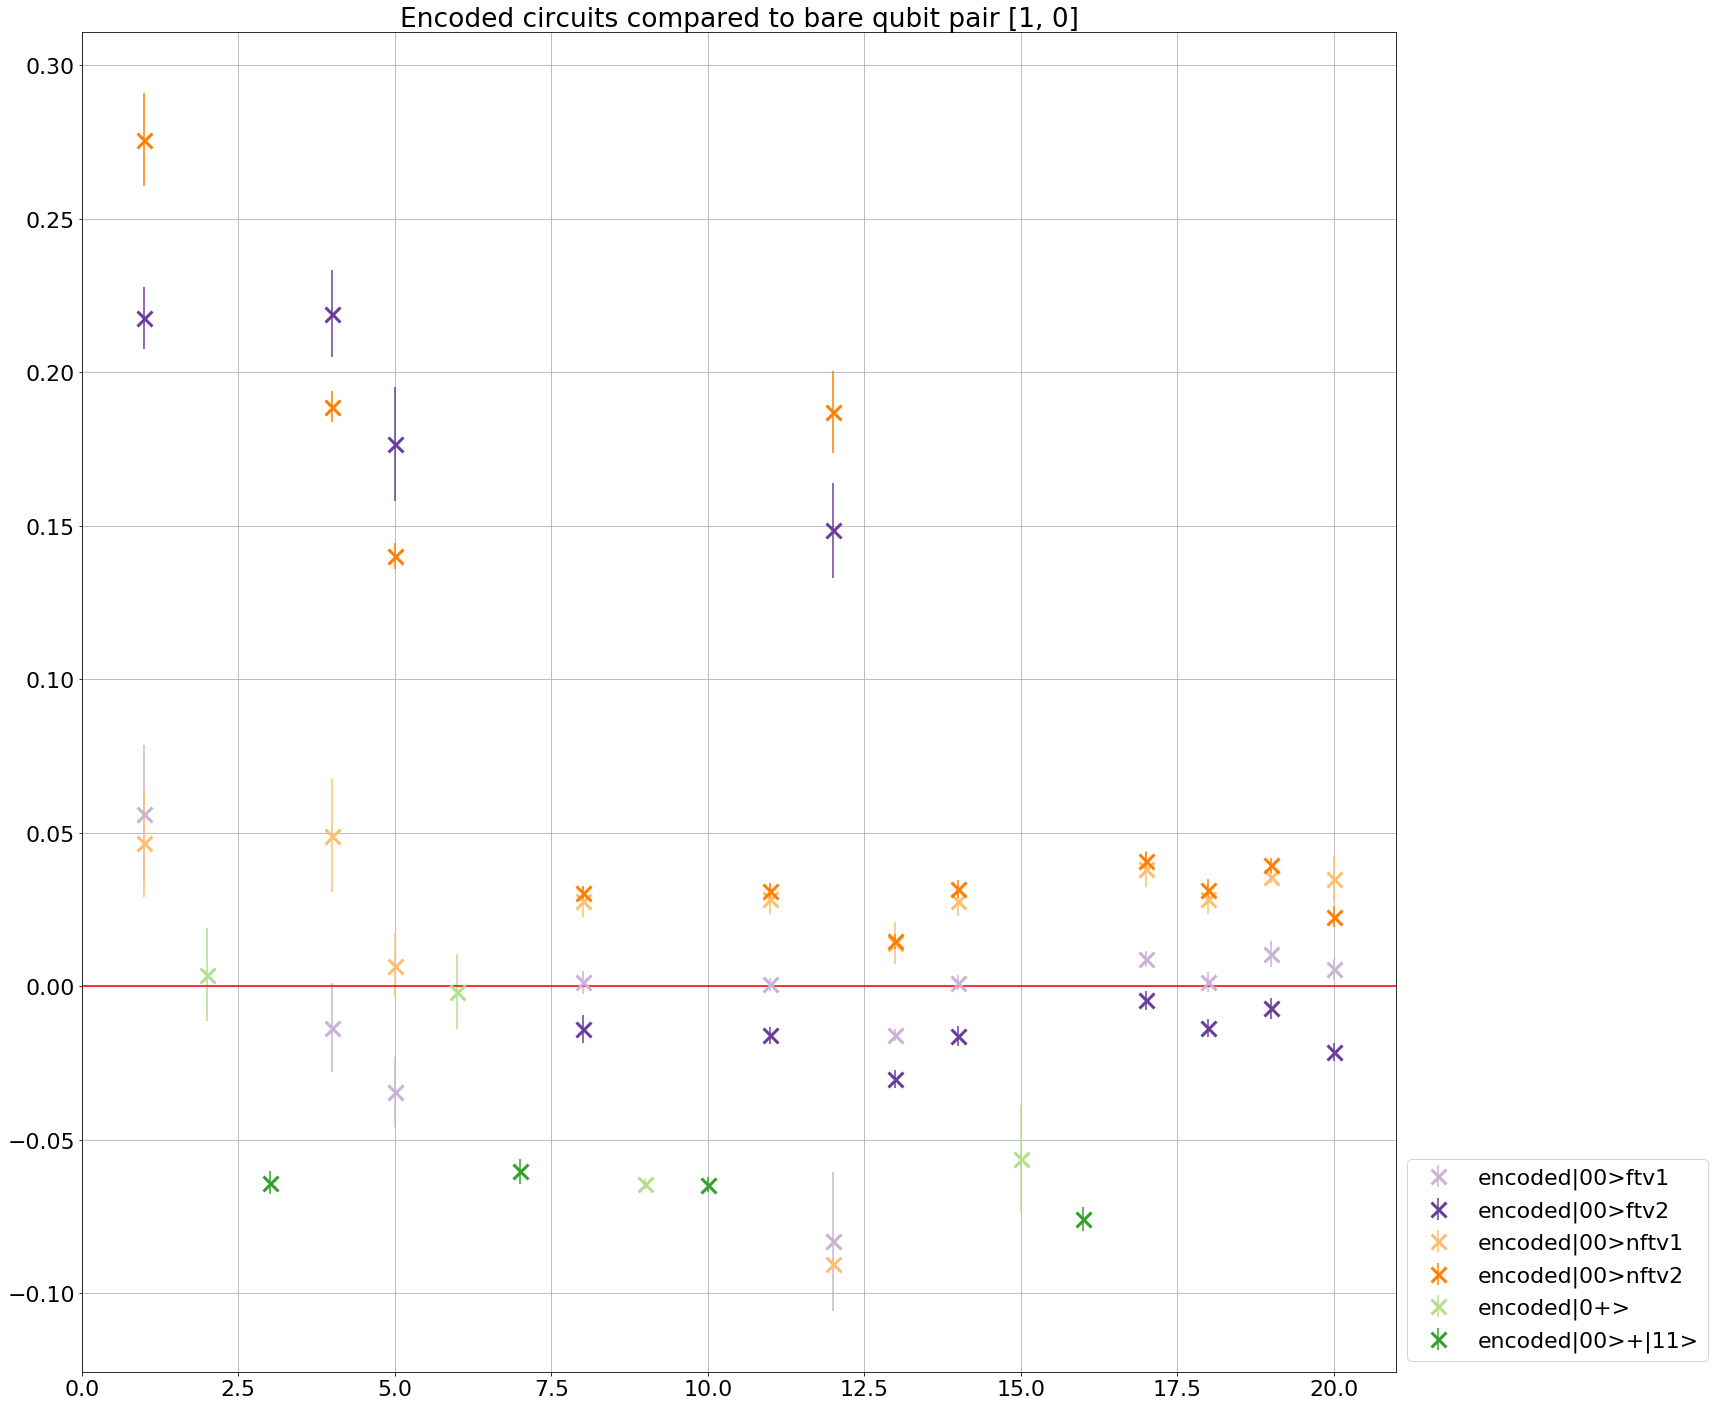

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [24]:
exptool.plot_everything_averaged_diff('data/Processed_data/', 
                                 logscaley=False,
                                 bareindex=0,
                                 ci=.99)

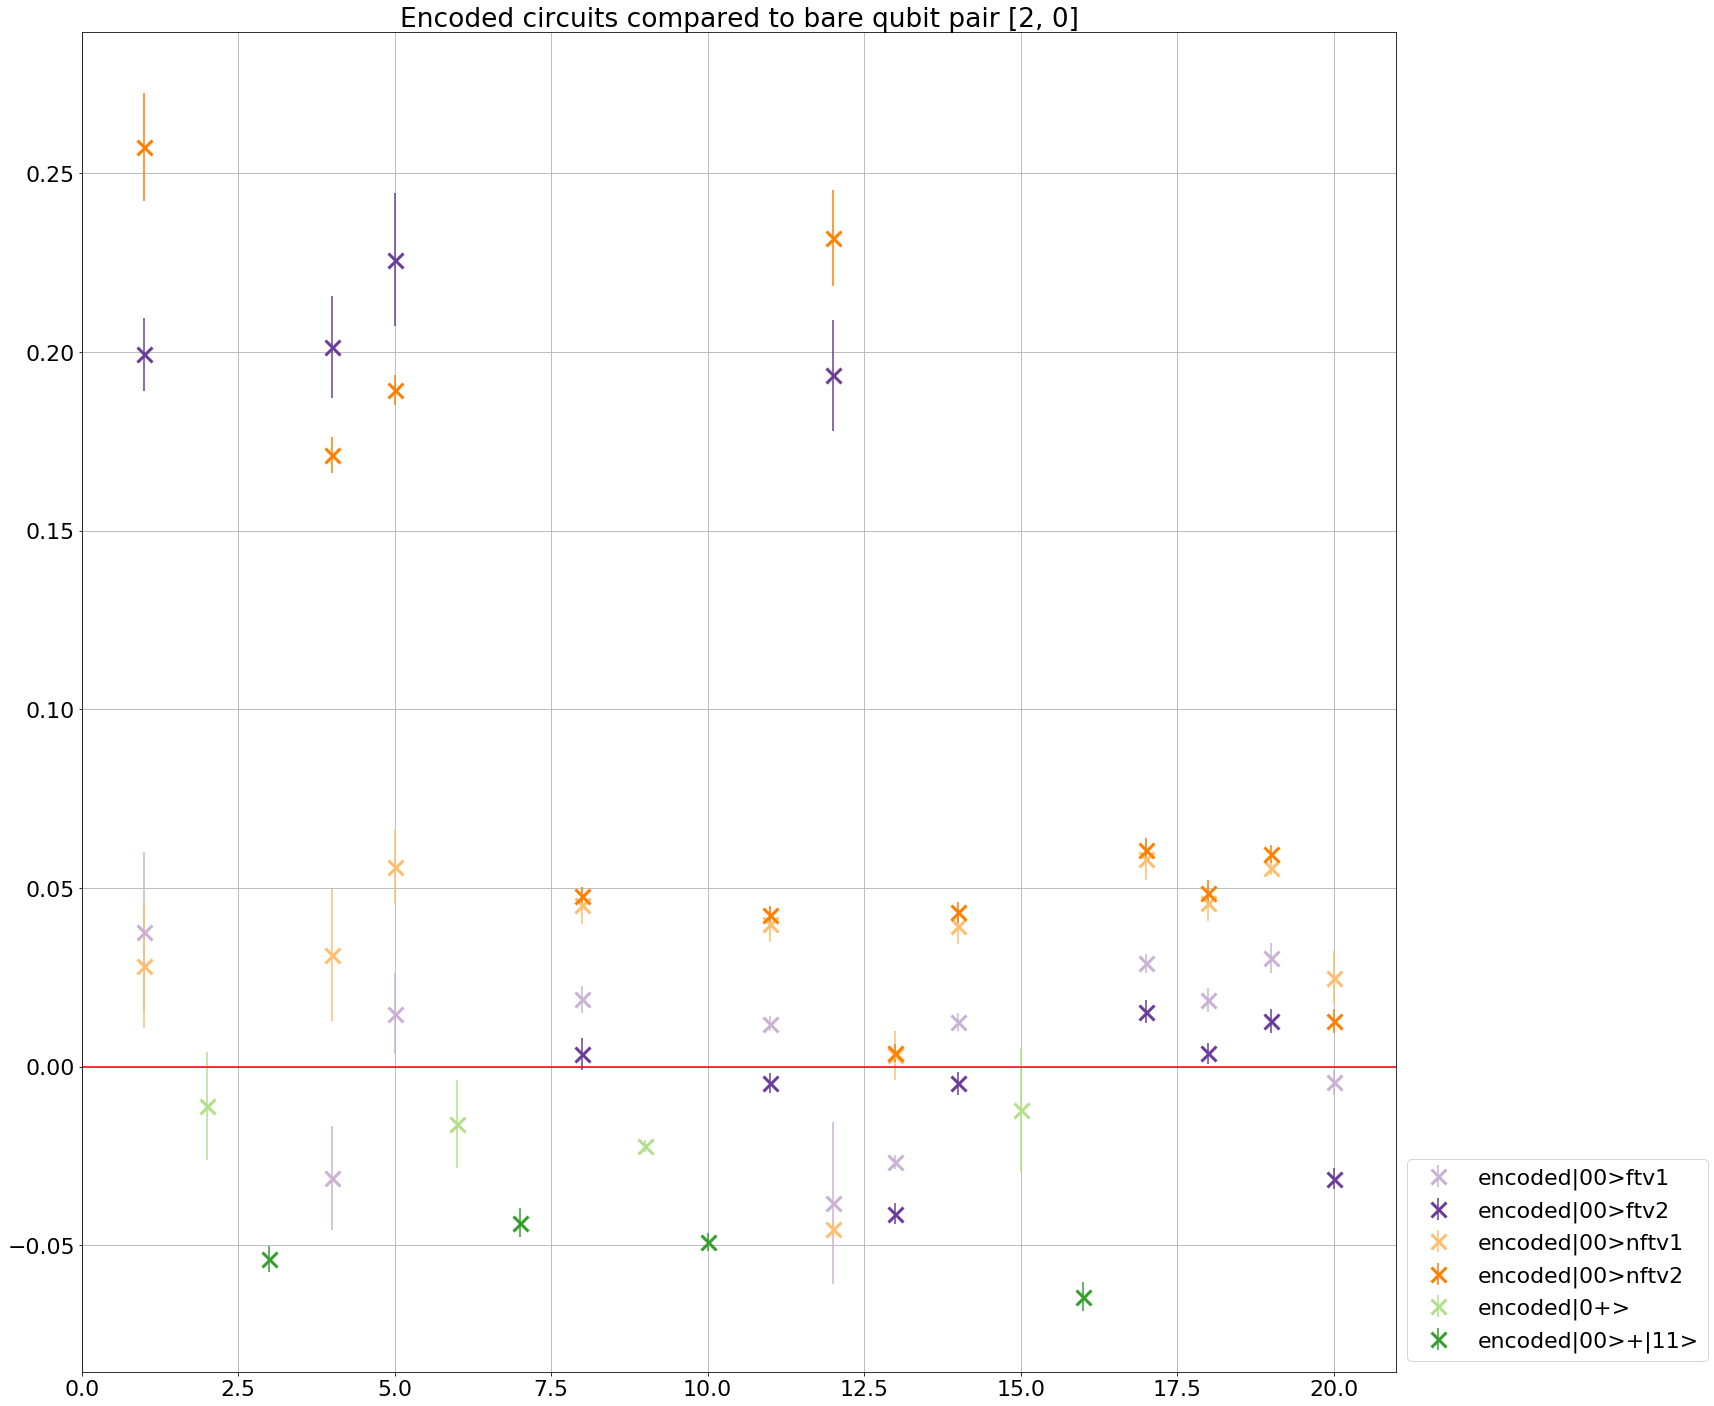

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [25]:
exptool.plot_everything_averaged_diff('data/Processed_data/', 
                                 logscaley=False,
                                 bareindex=1,
                                 ci=.99)

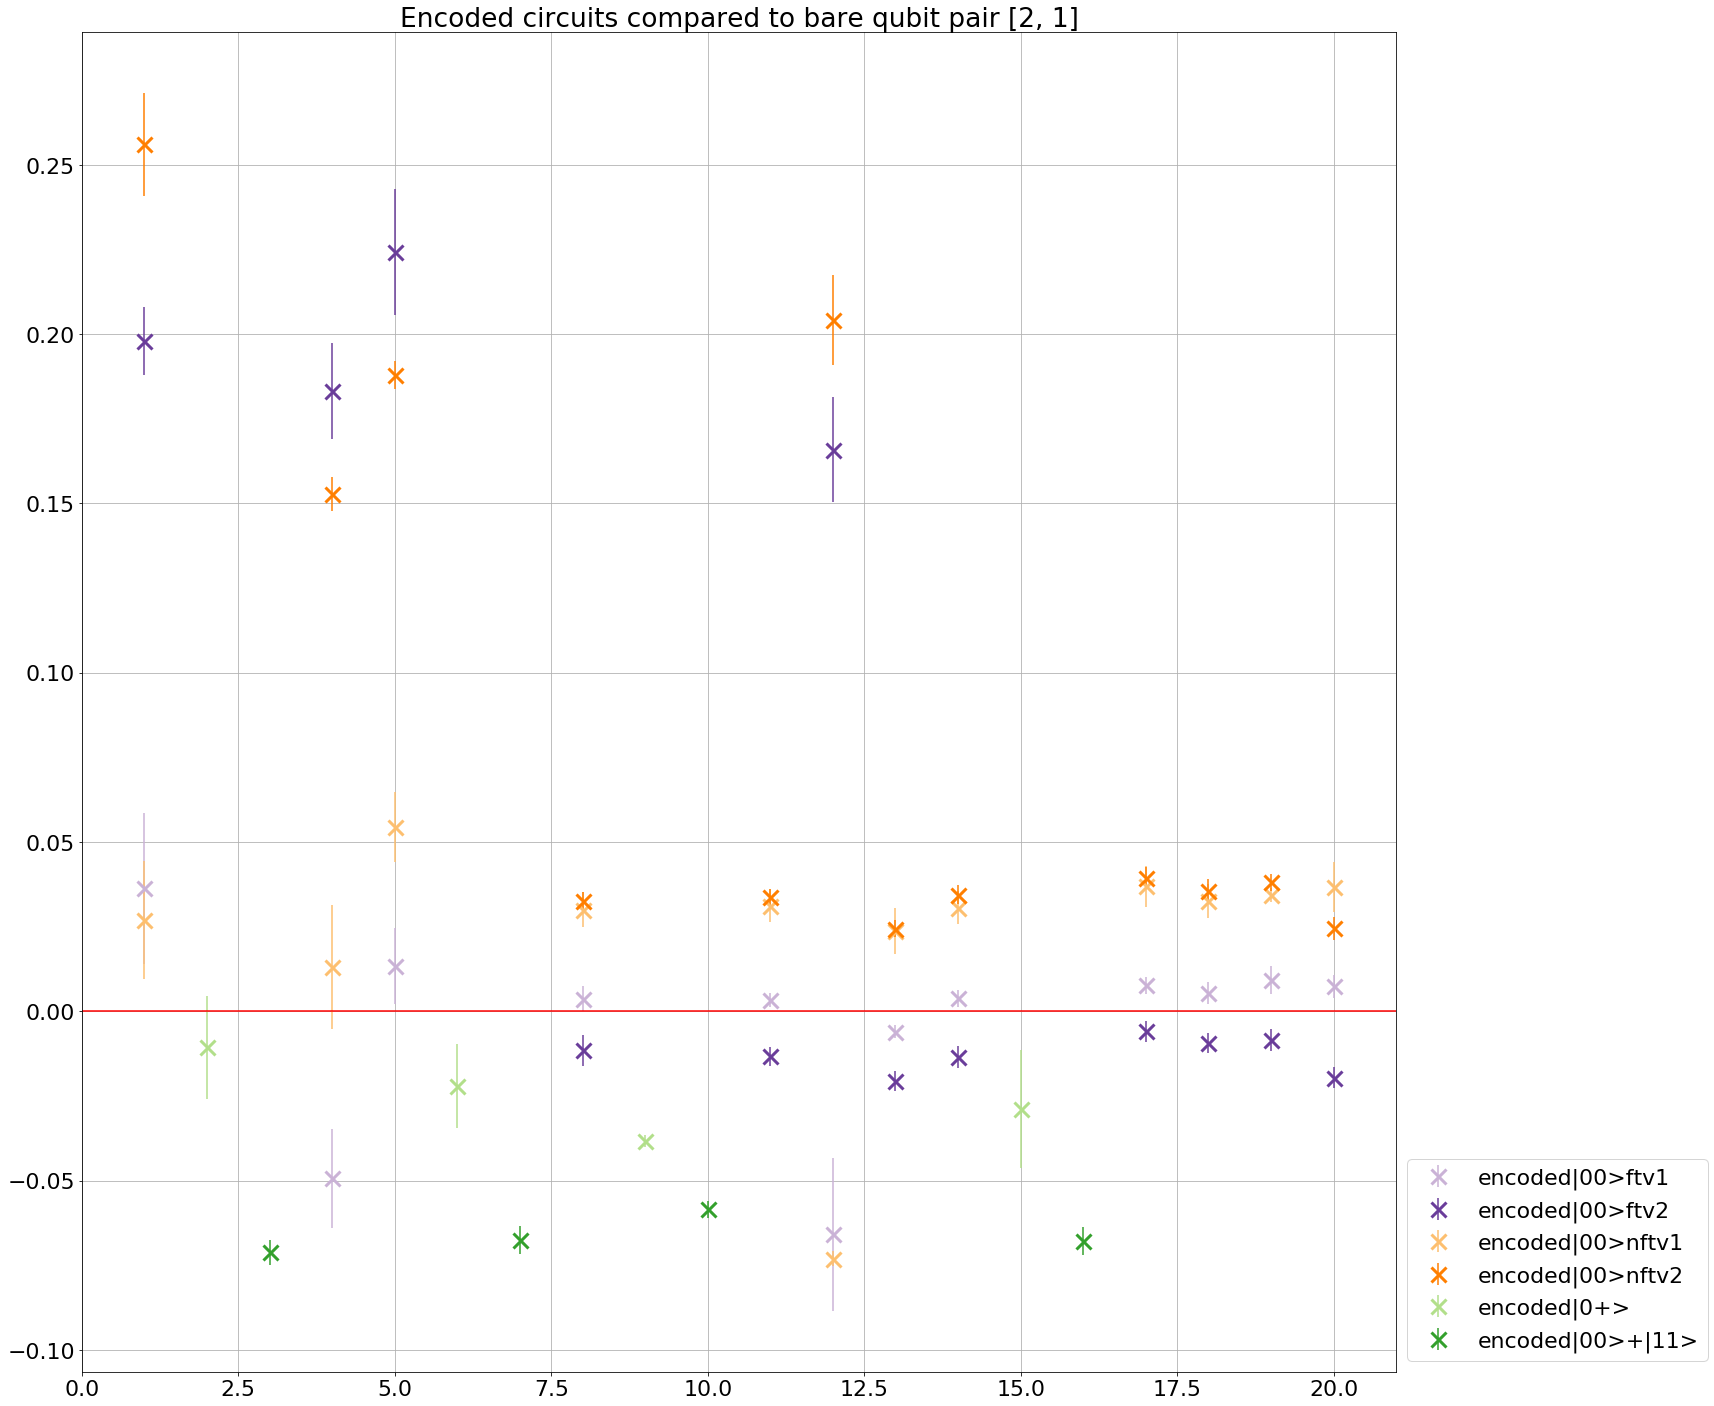

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [26]:
exptool.plot_everything_averaged_diff('data/Processed_data/', 
                                 logscaley=False,
                                 bareindex=2,
                                 ci=.99)

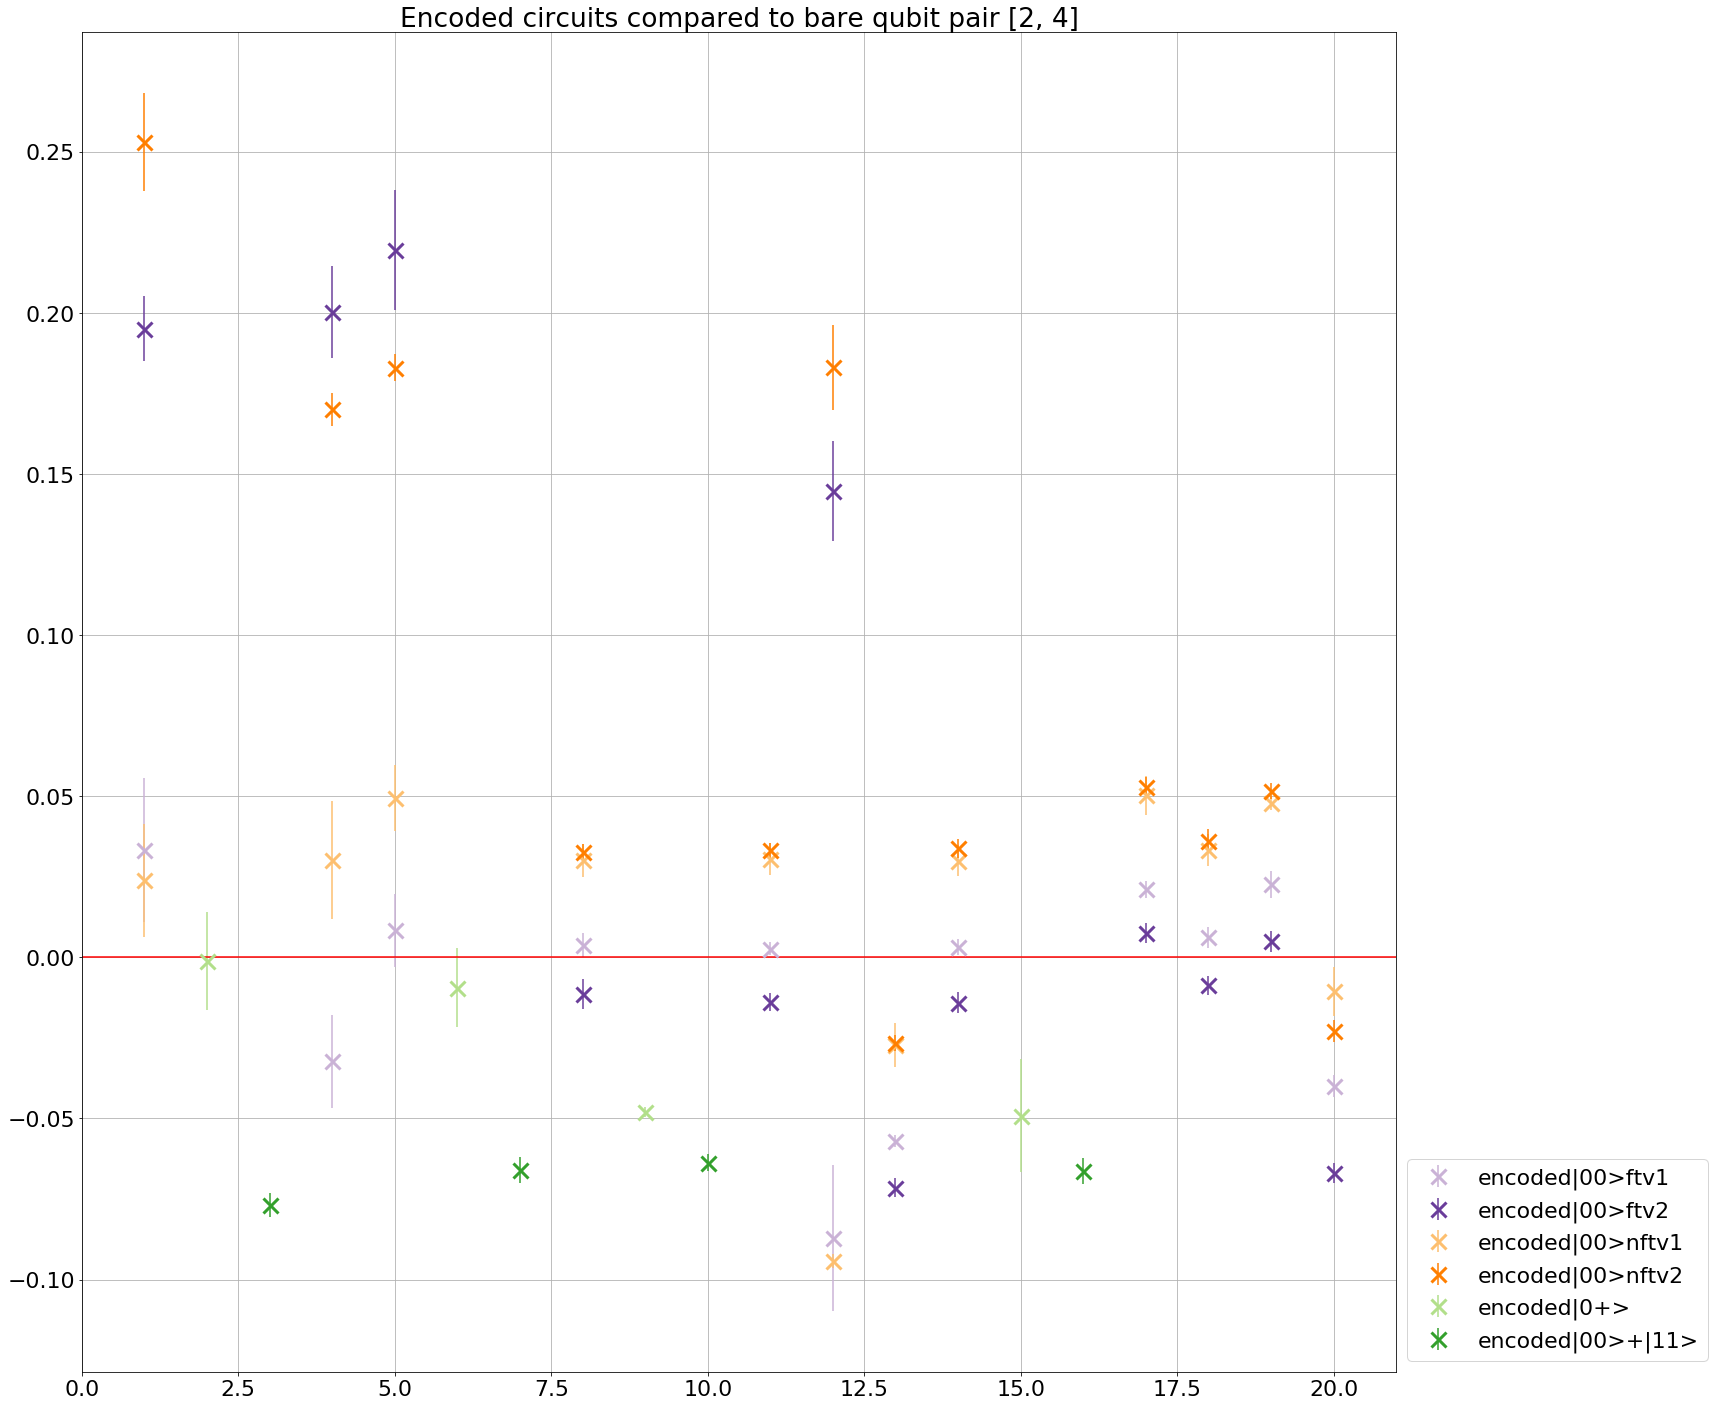

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [27]:
exptool.plot_everything_averaged_diff('data/Processed_data/', 
                                 logscaley=False,
                                 bareindex=3,
                                 ci=.99)

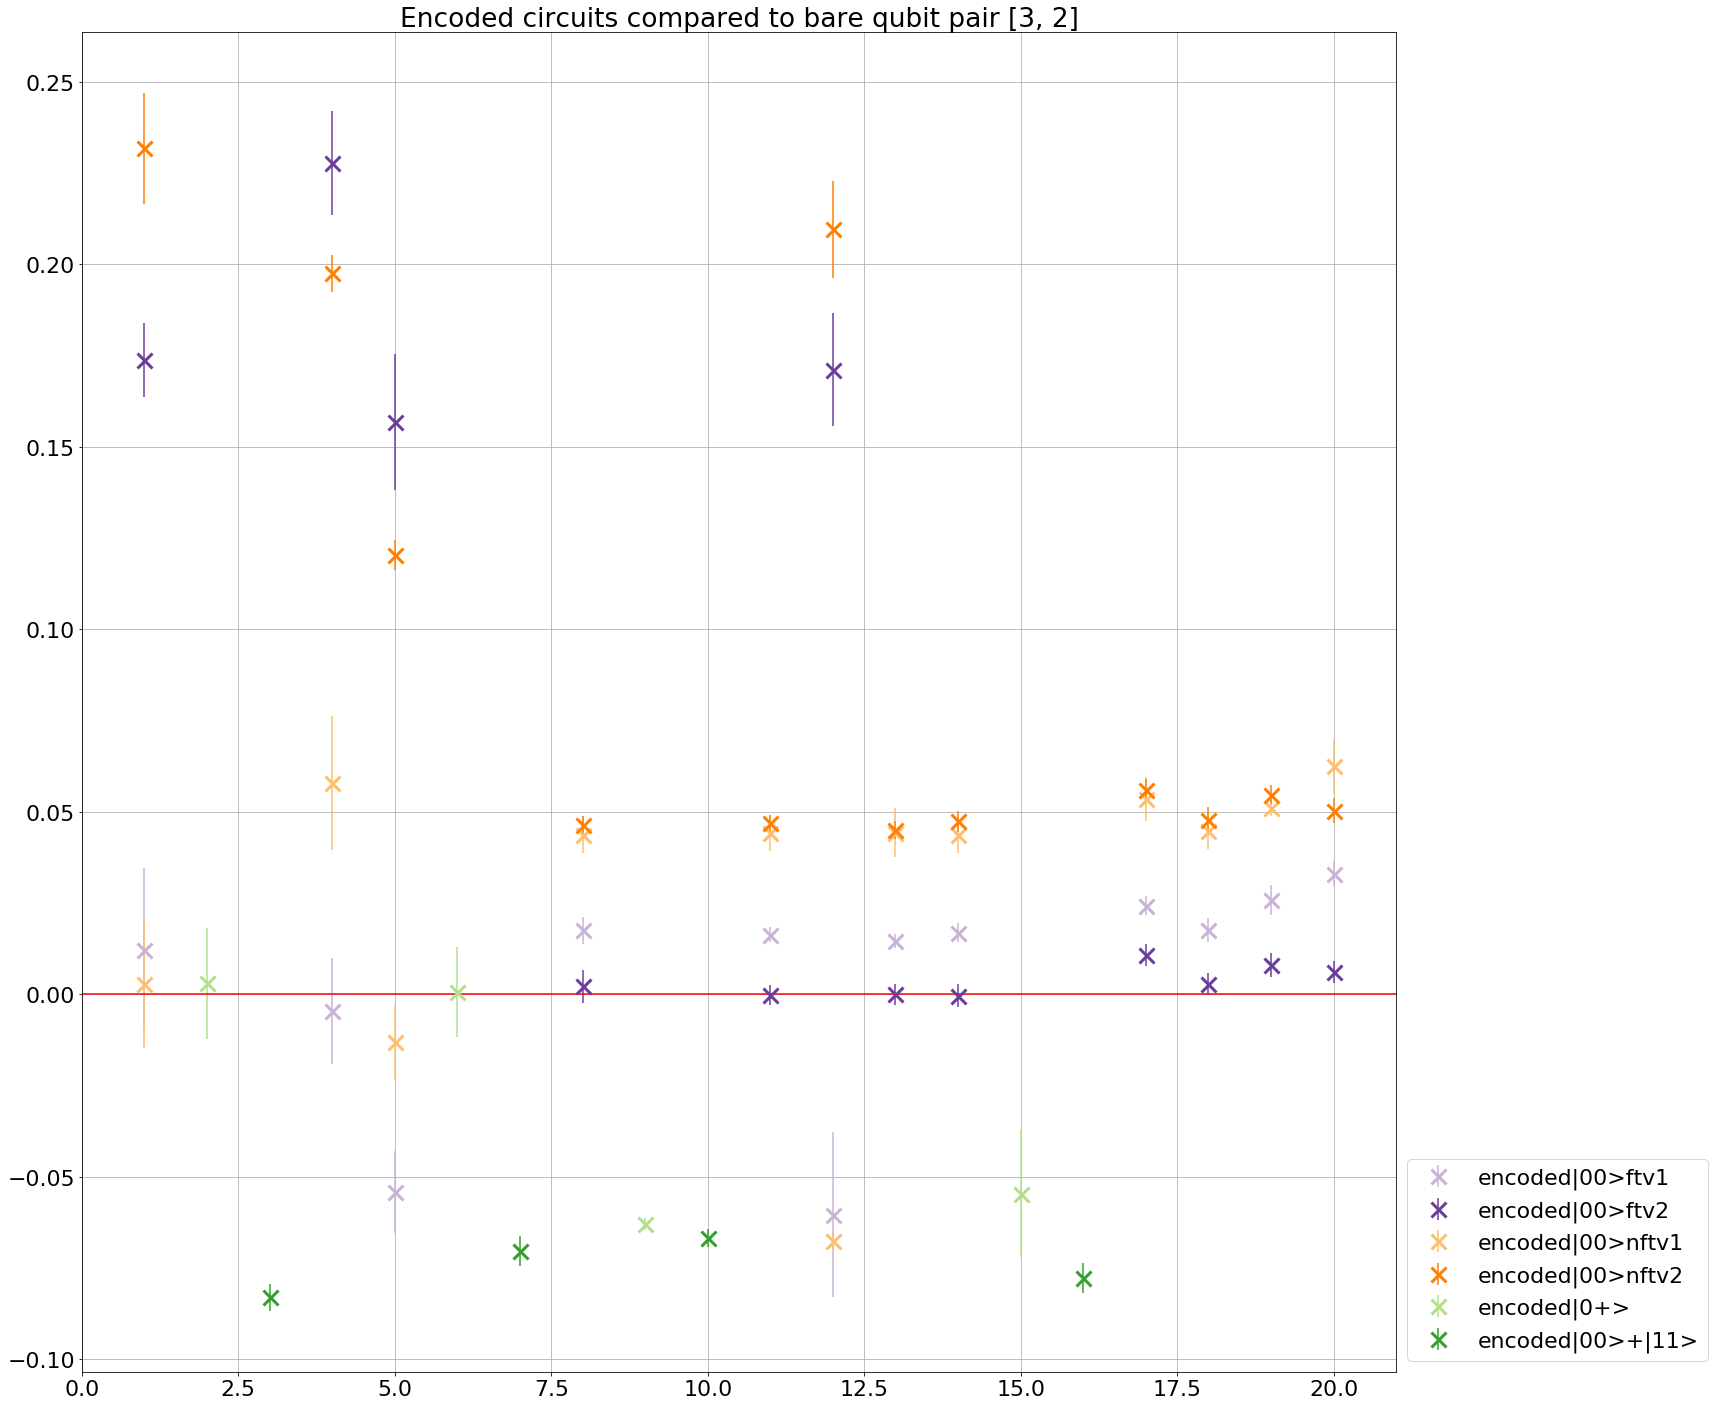

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [28]:
exptool.plot_everything_averaged_diff('data/Processed_data/', 
                                 logscaley=False,
                                 bareindex=4,
                                 ci=.99)

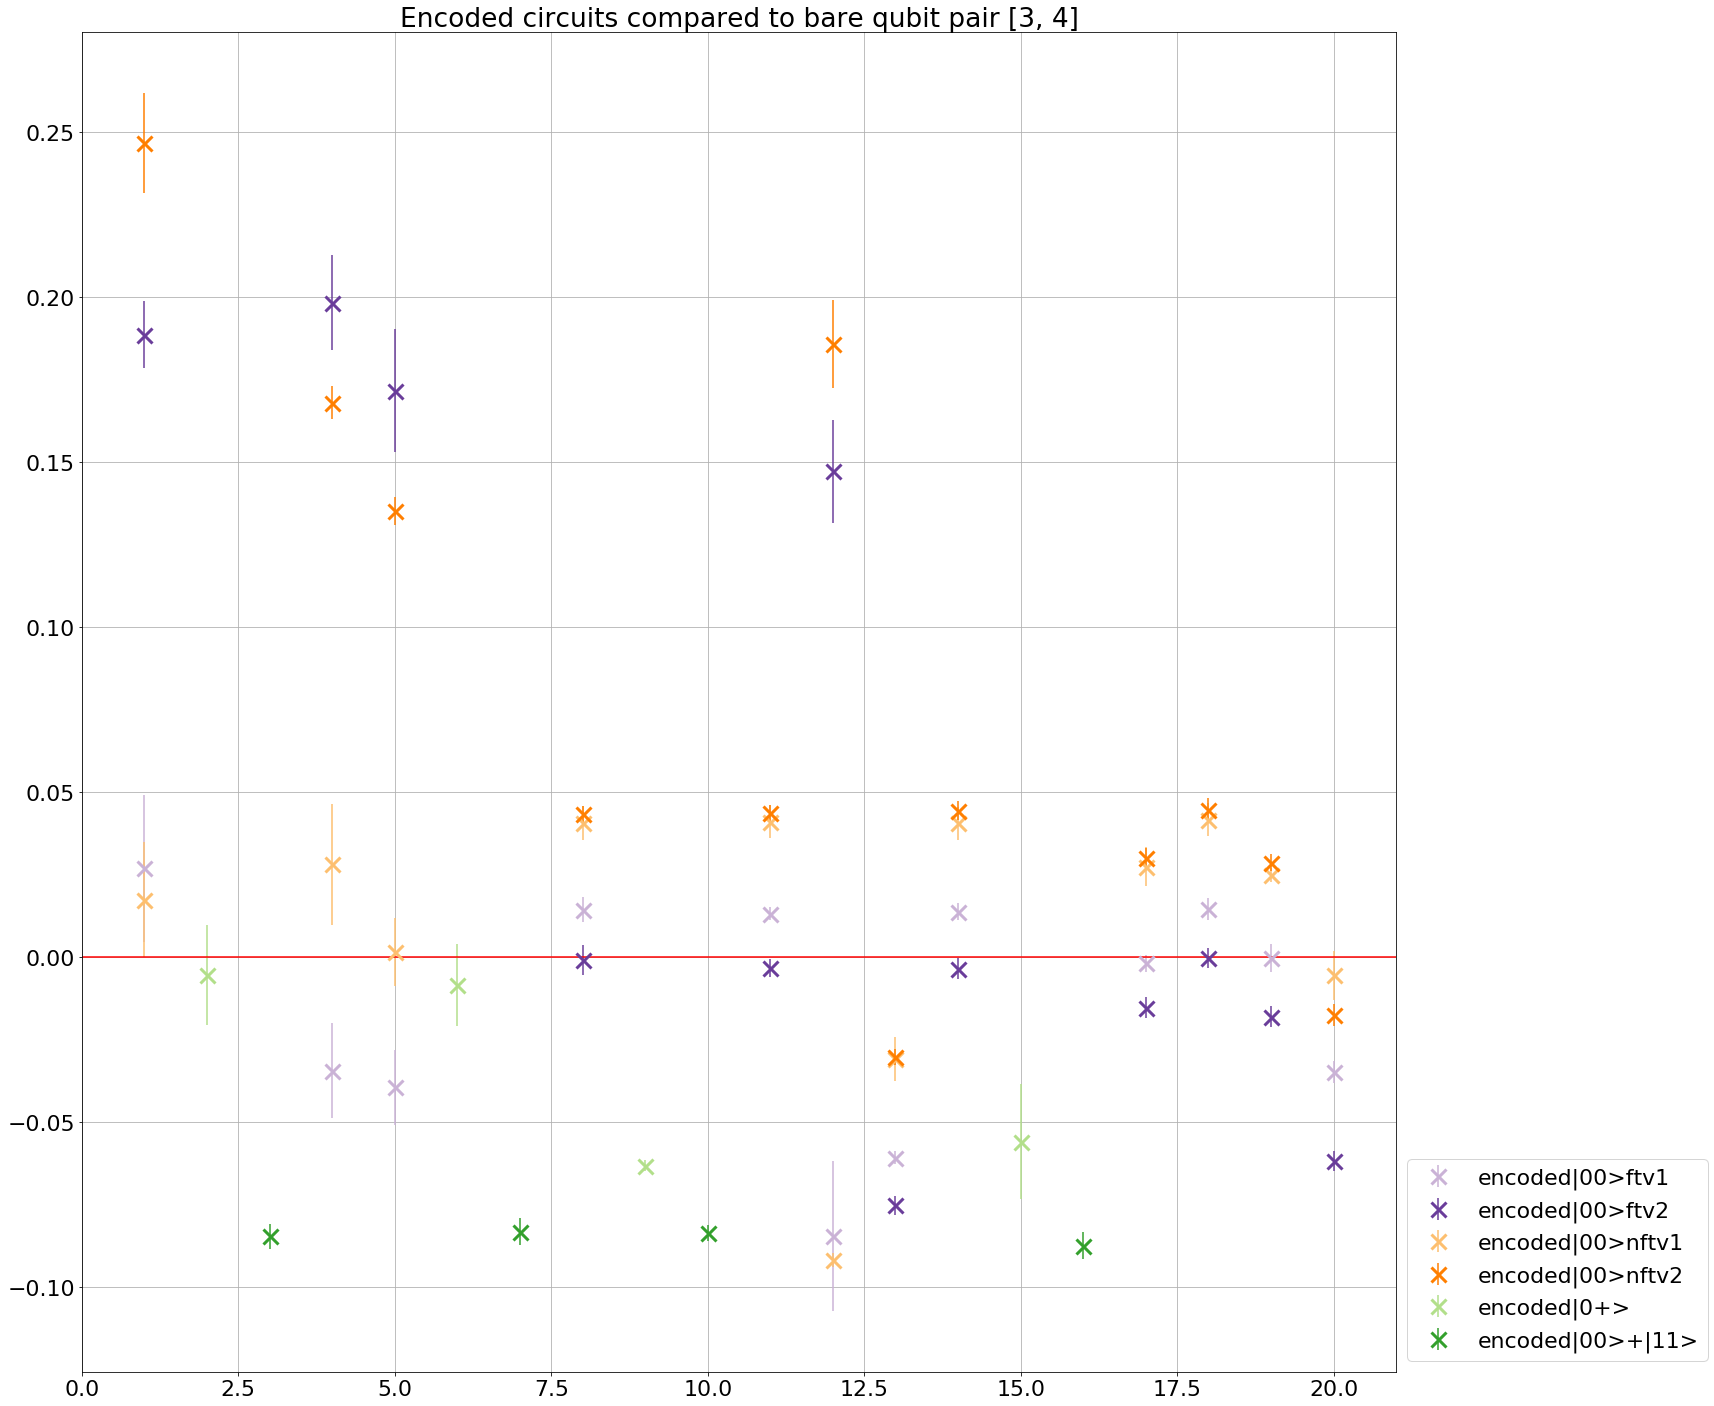

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [29]:
exptool.plot_everything_averaged_diff('data/Processed_data/', 
                                 logscaley=False,
                                 bareindex=5,
                                 ci=.99)

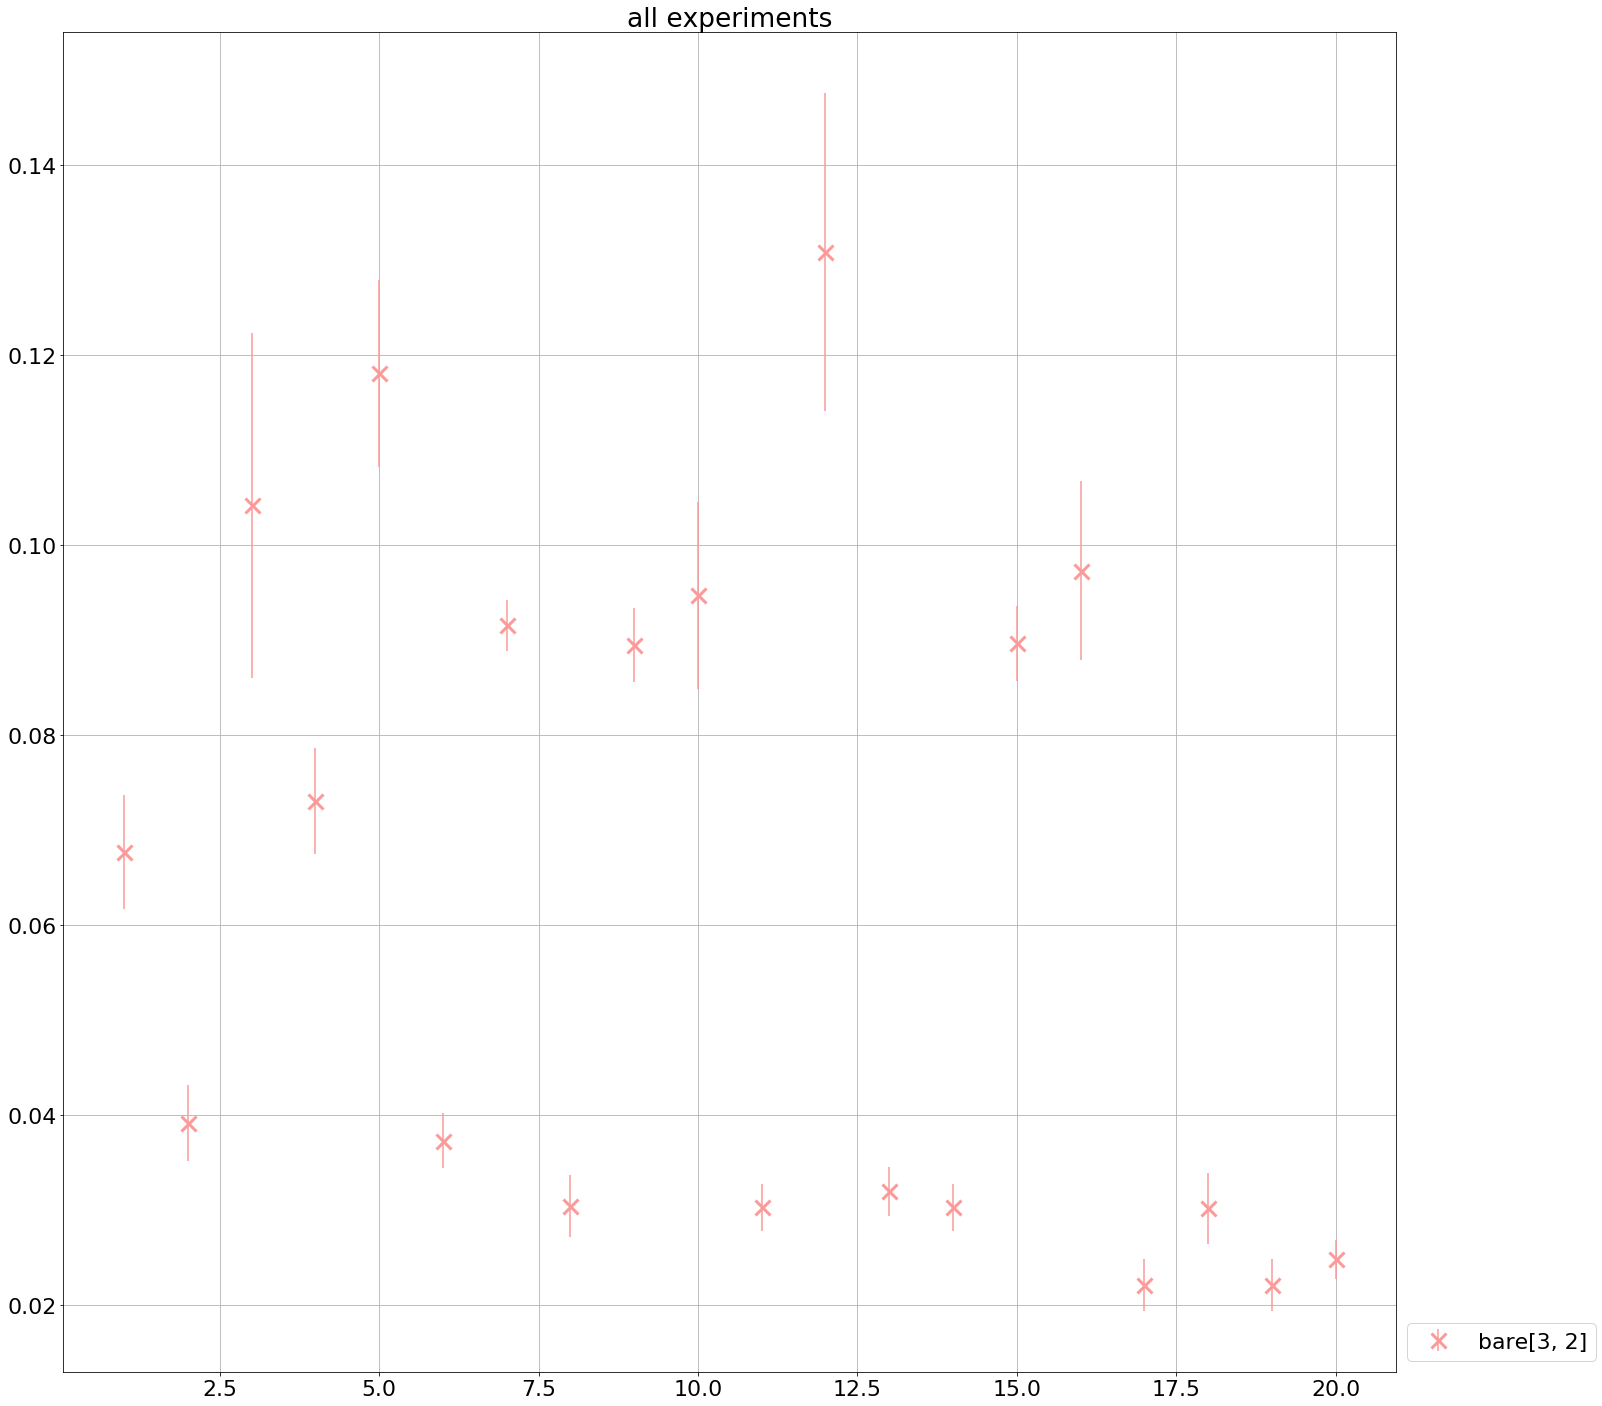

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998


In [30]:
exptool.plot_everything_averaged('data/Processed_data/', 
                                 logscaley=False,
                                 sublabels=exptool.PLOT_LABELS[4:5],
                                 ci=.99)

In [19]:
import os

In [20]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/home/christophe/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

In [21]:
file_list = os.listdir('data/Processed_data/')
n=0
for filename in file_list:
    n += exptool.repair_processed_data('data/Processed_data/'+filename, new_ext='')
print(n)

236


In [ ]:
# dic_t = {'name': 'eMX2-X1|00>nftv2', 'raw_counts': {'10000': 18, '10001': 108, '10010': 47, '10011': 93, '10100': 273, '10101': 12, '10110': 523, '10111': 11, '11000': 60, '11001': 335, '11010': 57, '11011': 346, '11100': 147, '11101': 21, '11110': 249, '11111': 24, '00000': 57, '00001': 152, '00010': 99, '00011': 296, '00100': 443, '00101': 43, '00110': 1981, '00111': 33, '01000': 100, '01001': 351, '01010': 162, '01011': 1358, '01100': 309, '01101': 39, '01110': 343, '01111': 102}, 'counts': {'00': 306, '01': 356, '10': 435, '11': 2041, 'err': 5054, 'total_valid': 3138}, 'qasm_count': 28, 'expected_distribution_array': np.array([ 0.,  0.,  0.,  1.]), 'version': 'encoded', 'experimental_distribution_array': np.array([ 0.09751434,  0.11344806,  0.13862333,  0.65041428]), 'post_selection_ratio': 0.383056640625, 'stat_dist': 0.34958572339069471, 'stand_dev': np.array([ 0.00529576,  0.0056614 ,  0.00616862,  0.00851227]), 'stat_dist_stand_dev': 0.0092359942888650178, 'calibration': {'lastUpdateDate': '2017-10-10T11:02:10.000Z', 'fridgeParameters': {'cooldownDate': '2017-09-07', 'Temperature': {'date': '2017-10-10T11:02:10Z', 'value': 0.021, 'unit': 'K'}}, 'qubits': [{'name': 'Q0', 'buffer': {'date': '2017-10-10T11:02:10Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2017-10-10T11:02:10Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2017-10-10T11:02:10Z', 'value': 50, 'unit': 'µs'}, 'T1': {'date': '2017-10-10T11:02:10Z', 'value': 58.6, 'unit': 'µs'}, 'frequency': {'date': '2017-10-10T11:02:10Z', 'value': 5.24613, 'unit': 'GHz'}, 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.000858490762927322}, 'readoutError': {'date': '2017-10-10T11:02:10Z', 'value': 0.035}}, {'name': 'Q1', 'buffer': {'date': '2017-10-10T11:02:10Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2017-10-10T11:02:10Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2017-10-10T11:02:10Z', 'value': 53.7, 'unit': 'µs'}, 'T1': {'date': '2017-10-10T11:02:10Z', 'value': 65, 'unit': 'µs'}, 'frequency': {'date': '2017-10-10T11:02:10Z', 'value': 5.30262, 'unit': 'GHz'}, 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.0013737021608475342}, 'readoutError': {'date': '2017-10-10T11:02:10Z', 'value': 0.054}}, {'name': 'Q2', 'buffer': {'date': '2017-10-10T11:02:10Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2017-10-10T11:02:10Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2017-10-10T11:02:10Z', 'value': 40.4, 'unit': 'µs'}, 'T1': {'date': '2017-10-10T11:02:10Z', 'value': 26.5, 'unit': 'µs'}, 'frequency': {'date': '2017-10-10T11:02:10Z', 'value': 5.35621, 'unit': 'GHz'}, 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.0017172252255832077}, 'readoutError': {'date': '2017-10-10T11:02:10Z', 'value': 0.029}}, {'name': 'Q3', 'buffer': {'date': '2017-10-10T11:02:10Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2017-10-10T11:02:10Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2017-10-10T11:02:10Z', 'value': 72, 'unit': 'µs'}, 'T1': {'date': '2017-10-10T11:02:10Z', 'value': 45.4, 'unit': 'µs'}, 'frequency': {'date': '2017-10-10T11:02:10Z', 'value': 5.43174, 'unit': 'GHz'}, 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.00128782749692391}, 'readoutError': {'date': '2017-10-10T11:02:10Z', 'value': 0.064}}, {'name': 'Q4', 'buffer': {'date': '2017-10-10T11:02:10Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2017-10-10T11:02:10Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2017-10-10T11:02:10Z', 'value': 20.8, 'unit': 'µs'}, 'T1': {'date': '2017-10-10T11:02:10Z', 'value': 42.2, 'unit': 'µs'}, 'frequency': {'date': '2017-10-10T11:02:10Z', 'value': 5.18244, 'unit': 'GHz'}, 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.00197489316929661}, 'readoutError': {'date': '2017-10-10T11:02:10Z', 'value': 0.056}}], 'multiQubitGates': [{'qubits': [1, 0], 'type': 'CX', 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.02406068322858046}, 'name': 'CX1_0'}, {'qubits': [2, 0], 'type': 'CX', 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.02392516461759317}, 'name': 'CX2_0'}, {'qubits': [2, 1], 'type': 'CX', 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.035763117147760204}, 'name': 'CX2_1'}, {'qubits': [2, 4], 'type': 'CX', 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.05419100812238378}, 'name': 'CX2_4'}, {'qubits': [3, 2], 'type': 'CX', 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.023112318348217586}, 'name': 'CX3_2'}, {'qubits': [3, 4], 'type': 'CX', 'gateError': {'date': '2017-10-10T11:02:10Z', 'value': 0.03658313664371693}, 'name': 'CX3_4'}], 'version': '3.0'}}

In [88]:
dic_t

{'calibration': {'fridgeParameters': {'Temperature': {'date': '2017-10-10T11:02:10Z',
    'unit': 'K',
    'value': 0.021},
   'cooldownDate': '2017-09-07'},
  'lastUpdateDate': '2017-10-10T11:02:10.000Z',
  'multiQubitGates': [{'gateError': {'date': '2017-10-10T11:02:10Z',
     'value': 0.02406068322858046},
    'name': 'CX1_0',
    'qubits': [1, 0],
    'type': 'CX'},
   {'gateError': {'date': '2017-10-10T11:02:10Z',
     'value': 0.02392516461759317},
    'name': 'CX2_0',
    'qubits': [2, 0],
    'type': 'CX'},
   {'gateError': {'date': '2017-10-10T11:02:10Z',
     'value': 0.035763117147760204},
    'name': 'CX2_1',
    'qubits': [2, 1],
    'type': 'CX'},
   {'gateError': {'date': '2017-10-10T11:02:10Z',
     'value': 0.05419100812238378},
    'name': 'CX2_4',
    'qubits': [2, 4],
    'type': 'CX'},
   {'gateError': {'date': '2017-10-10T11:02:10Z',
     'value': 0.023112318348217586},
    'name': 'CX3_2',
    'qubits': [3, 2],
    'type': 'CX'},
   {'gateError': {'date': '2017-1

In [48]:
exptool.CODEWORDS

[['0000', '1111'], ['1100', '0011'], ['1010', '0101'], ['1001', '0110']]

In [49]:
exptool.MAPPED_CODEWORDS

[['00000', '11110'],
 ['01100', '10010'],
 ['01010', '10100'],
 ['11000', '00110']]

In [50]:
exptool.CIRCUITS

[[['X1', 'HHS', 'CZ', 'X2'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['HHS', 'Z1', 'CZ'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['HHS', 'Z1', 'Z2'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['HHS', 'Z2', 'CZ'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['Z2', 'X2'], '|00>+|11>', [0, 0.5, 0.5, 0]],
 [['X1', 'Z2'], '|0+>', [0, 0, 0.5, 0.5]],
 [['HHS', 'Z1'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['HHS', 'CZ'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['X1', 'X2'], '|00>', [0, 0, 0, 1]],
 [['HHS', 'Z2'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['X1'], '|00>+|11>', [0, 0.5, 0.5, 0]],
 [['X1'], '|0+>', [0, 0, 0.5, 0.5]],
 [['HHS'], '|00>', [0.25, 0.25, 0.25, 0.25]],
 [['Z2'], '|00>+|11>', [0.5, 0, 0, 0.5]],
 [['Z2'], '|0+>', [0.5, 0.5, 0, 0]],
 [['X1'], '|00>', [0, 0, 1, 0]],
 [['X2'], '|00>', [0, 1, 0, 0]],
 [[], '|00>+|11>', [0.5, 0, 0, 0.5]],
 [[], '|0+>', [0.5, 0.5, 0, 0]],
 [[], '|00>', [1, 0, 0, 0]]]

In [72]:
dict_cn

{'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nmeasure q[3] -> c[3];\nu2(0.0,3.141592653589793) q[2];\ncx q[2],q[4];\nmeasure q[2] -> c[2];\nmeasure q[4] -> c[4];\nmeasure q[1] -> c[1];\nmeasure q[0] -> c[0];\n': ['bM|00>+|11>[2, 4]'],
 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nmeasure q[3] -> c[3];\nu2(0.0,3.141592653589793) q[2];\ncx q[2],q[4];\nu1(3.141592653589793) q[4];\nmeasure q[4] -> c[4];\nmeasure q[2] -> c[2];\nmeasure q[1] -> c[1];\nmeasure q[0] -> c[0];\n': ['bMZ2|00>+|11>[2, 4]'],
 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nmeasure q[3] -> c[3];\nu2(0.0,3.141592653589793) q[2];\ncx q[2],q[4];\nu1(3.141592653589793) q[4];\nu3(3.141592653589793,0.0,3.141592653589793) q[4];\nmeasure q[4] -> c[4];\nmeasure q[2] -> c[2];\nmeasure q[1] -> c[1];\nmeasure q[0] -> c[0];\n': ['bMX2-Z2|00>+|11>[2, 4]'],
 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nmeasure q[3] -> c[3];\nu2(0.0,3.141592653589793) q[2];\ncx q[

In [75]:
print('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nmeasure q[4] -> c[4];\nmeasure q[3] -> c[3];\nmeasure q[2] -> c[2];\nmeasure q[1] -> c[1];\nu2(0.0,3.141592653589793) q[0];\nmeasure q[0] -> c[0];\n','bM|0+>[1, 0]','bM|0+>[2, 0]')

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
measure q[4] -> c[4];
measure q[3] -> c[3];
measure q[2] -> c[2];
measure q[1] -> c[1];
u2(0.0,3.141592653589793) q[0];
measure q[0] -> c[0];
 bM|0+>[1, 0] bM|0+>[2, 0]


In [106]:
l = [1,2,3,4,5,6,7]
[i for i in l if i % 2 == 0]

[2, 4, 6]

In [102]:
l.index(6)

5

In [137]:
s = '123456789101112'
s[2:len(s)-6]

'3456789'

In [146]:
sum([len(a) for a in [[0.1925048828125, 0.0601806640625, 0.0550537109375, 0.05419921875, 0.0728759765625, 0.066650390625, 0.058837890625, 0.062744140625, 0.0592041015625, 0.06787109375, 0.053955078125, 0.07177734375, 0.0623779296875, 0.0635986328125, 0.0628662109375, 0.053466796875, 0.0679931640625, 0.0439453125], [0.06005859375, 0.0555419921875, 0.061767578125, 0.0545654296875, 0.057861328125, 0.061767578125, 0.0780029296875, 0.070068359375, 0.0614013671875, 0.0662841796875, 0.0626220703125, 0.0618896484375, 0.0582275390625], [0.0621337890625, 0.0572509765625, 0.056640625, 0.064697265625, 0.0634765625], [0.0538330078125, 0.0552978515625, 0.0545654296875, 0.065185546875, 0.0653076171875, 0.060302734375, 0.0709228515625, 0.0535888671875, 0.053955078125, 0.046142578125, 0.053466796875, 0.04736328125, 0.053466796875, 0.0653076171875, 0.064208984375, 0.059814453125, 0.0635986328125, 0.058349609375, 0.06298828125, 0.1900634765625, 0.0677490234375, 0.0535888671875, 0.0631103515625, 0.0660400390625, 0.0557861328125, 0.0560302734375, 0.0587158203125, 0.061279296875, 0.0572509765625, 0.07373046875, 0.056640625, 0.055419921875, 0.0596923828125, 0.0689697265625, 0.0623779296875, 0.067626953125, 0.064697265625, 0.06298828125, 0.0732421875, 0.0750732421875, 0.06982421875, 0.0601806640625, 0.0596923828125, 0.052490234375, 0.0621337890625, 0.0706787109375, 0.052734375, 0.057373046875, 0.0582275390625, 0.0572509765625, 0.0640869140625], [0.0504150390625, 0.04638671875, 0.0582275390625, 0.0447998046875, 0.048828125], []]])

92

In [282]:
exptool.CIRCUIT_NAMES

['M|00>',
 'M|0+>',
 'M|00>+|11>',
 'MX2|00>',
 'MX1|00>',
 'MZ2|0+>',
 'MZ2|00>+|11>',
 'MHHS|00>',
 'MX1|0+>',
 'MX1|00>+|11>',
 'MZ2-HHS|00>',
 'MX2-X1|00>',
 'MCZ-HHS|00>',
 'MZ1-HHS|00>',
 'MZ2-X1|0+>',
 'MX2-Z2|00>+|11>',
 'MCZ-Z2-HHS|00>',
 'MZ2-Z1-HHS|00>',
 'MCZ-Z1-HHS|00>',
 'MX2-CZ-HHS-X1|00>']

In [238]:
'aa' in 'iushjbfaiusdaajkndfiuhw'

True

In [30]:
25592/(12*20)

106.63333333333334